In [1]:
# Import Julia packages
using DrWatson
@quickactivate
using Revise
using LinearAlgebra
using DelimitedFiles
using SparseArrays
using StaticArrays
using BlockArrays
using CairoMakie
using UnPack
using FromFile
using GeometryBasics
using Random
using Colors
using JLD2
using LaTeXStrings
using Glob
using Printf
using ColorSchemes


@from "$(projectdir())/src/VertexModelContainers.jl" using VertexModelContainers
@from "$(projectdir())/src/Laplacians.jl" using Laplacians
@from "$(projectdir())/src/AnalysisFunctions.jl" using AnalysisFunctions
@from "$(projectdir())/src/CellProperties.jl" using CellProperties

In [ ]:
function makeEold(matrices, params)


    @unpack edgeTangents,A, Ā, B, C= matrices
    @unpack nCells, nEdges, nVerts = params



    vertexAreas=zeros(nVerts)
    edgeMidpointLinks=fill(SVector{2, Float64}(zeros(2)), (nCells, nVerts))

    nzC = findnz(C)
    ikPairs = tuple.(nzC[1],nzC[2])
    for (i,k) in ikPairs
        for j=1:nEdges
            edgeMidpointLinks[i,k] = edgeMidpointLinks[i,k] .+ 0.5.*B[i,j]*edgeTangents[j]*Ā[j,k]
        end
    end


    ##Check k_is length ==1

    for k=1:nVerts

        k_is = findall(x->x!=0, C[:,k])
        if length(k_is) == 1
            edgesSharedBy_i1_And_k = findall(x->x!=0, B[k_is[1],:])∩findall(x->x!=0, A[:,k])
            vertexAreas[k] = 0.5^3*norm([edgeTangents[edgesSharedBy_i1_And_k[1]]...,0.0]×[edgeTangents[edgesSharedBy_i1_And_k[2]]...,0.0])
        elseif length(k_is) == 2
            edgesSharedBy_i1_And_k = findall(x->x!=0, B[k_is[1],:])∩findall(x->x!=0, A[:,k])
            vertexAreas[k] = 0.5^3*norm([edgeTangents[edgesSharedBy_i1_And_k[1]]...,0.0]×[edgeTangents[edgesSharedBy_i1_And_k[2]]...,0.0])
            edgesSharedBy_i2_And_k = findall(x->x!=0, B[k_is[2],:])∩findall(x->x!=0, A[:,k])
            vertexAreas[k] += 0.5^3*norm([edgeTangents[edgesSharedBy_i2_And_k[1]]...,0.0]×[edgeTangents[edgesSharedBy_i2_And_k[2]]...,0.0])
        else
            vertexAreas[k] = 0.5*norm([edgeMidpointLinks[k_is[1], k]...,0.0]×[edgeMidpointLinks[k_is[2],k]...,0.0])
        end
    end

    E=Diagonal(vertexAreas)

    return(E)

end

In [235]:
f=Glob.glob("new_energy/test_model/at*/tsit5/*","C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims" )[5]
@unpack R, matrices, params = load(datadir(f,"frameData","systemData100.jld2"))
@unpack nCells,nVerts, γ, L₀ = params
@unpack cellAreas,cellPerimeters, cellTensions, cellPressures, cellEdgeCount, edgeTangents,vertexAreas,A,Ā,B,B̄,C, ϵ = matrices
mkpath(datadir(f,"eigenmodes"))

┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.MatricesContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


┌ Warning: type VertexModel...\VertexModelContainers.jl.VertexModelContainers.ParametersContainer does not exist in workspace; reconstructing
└ @ JLD2 C:\Users\v35431nc\.julia\packages\JLD2\cHcDY\src\data\reconstructing_datatypes.jl:605


"C:\\Users\\v35431nc\\Documents\\VM_code\\VertexModel\\data\\sims\\new_energy\\test_model\\at10rt7\\tsit5\\L₀=1.0_nCells=127_realTimetMax=86400.0_γ=1.0_24-01-28-23-32-05\\eigenmodes"

In [236]:
G=makeGnew(params, matrices) #update for new model
M=makeM(matrices)



Lv=makeEvLvnew(M, G, vertexAreas)
Lc=makeEvLcnew(M, G, vertexAreas)
X=makeX(params, matrices)
g=vcat(cellPressures, -cellTensions)

gX=Matrix{SMatrix{2,2,Float64,4}}(undef,nVerts,nVerts)
fill!(gX,@SMatrix zeros(2,2))

for α=1:2*nCells
     gX+=g[α]X[α, :,:]
end

In [ ]:
G

In [ ]:
((M*inv(Diagonal(vertexAreas)))*M')*G

inv(Diagonal(vertexAreas))*(M'*(G*M))

In [ ]:
function makeE(matrices, params)


    @unpack edgeTangents,A, Ā, B,B̄, ϵ= matrices
    dAdr= -1/2*B*Diagonal([(ϵ*T)' for T in edgeTangents])*Ā
    αik=transpose.(dAdr).*(B̄*Diagonal(edgeTangents)*A)
    Ek=vec((1/8).*sum(αik, dims=1)')
    E=Diagonal(Ek)
    return(E)
end

In [ ]:
makeE(matrices, params)

In [238]:
dAdr=-1/2*B*Diagonal([(ϵ*T) for T in edgeTangents])*Ā
#dLdr=Sum j B̄ᵢⱼ Aⱼₖ t̂ⱼ   = B̄ diag(t̂) A
dLdr= B̄*Diagonal((edgeTangents)./norm.(edgeTangents))*A

Mtemp=vcat(dAdr,dLdr)
Mflat=transpose(reshape(reinterpret(Float64,[vcat(Matrix(Mtemp)[x,:]...) for x in collect(1:2*nCells)]), ( 2*nVerts, 2*nCells)))

254×588 transpose(reshape(reinterpret(Float64, ::Vector{SVector{588, Float64}}), 588, 254)) with eltype Float64:
  0.0        0.0        0.0          0.0  …   0.0       0.0  0.0  0.0  0.0
 -2.167e-7  -0.214036   0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0     -0.214036  0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0  …   0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  0.0        0.0        0.0          0.0      0.0       0.0  0.0  0.0  0.0
  ⋮                                       ⋱                  ⋮         
  0.0        0.0        0.0          0.0  …   0.0       0.0  0.0 

In [239]:


#E=makeE(matrices, params)
E=Diagonal(vertexAreas)
Eflat=kron(E,Matrix(1.0I, 2, 2))

LcE=Matrix(Lc)
evalLc,evecLctemp=LAPACK.syev!('V','U',deepcopy(sqrt(G)*Matrix(LcE)*inv(sqrt(G))))
evecLc=inv(sqrt(G))*evecLctemp

LvE=Matrix(Lv)
evalLv,evecLvtemp=LAPACK.syev!('V','U',deepcopy(sqrt(Eflat)*Matrix(mortar(LvE))*inv(sqrt(Eflat))))
evecLv=inv(sqrt(Eflat))*evecLvtemp

H=Matrix(mortar(LvE)).+Matrix(mortar(inv(E)*gX))
evalH,evecHtemp=LAPACK.syev!('V','U',deepcopy(sqrt(Eflat)*H*inv(sqrt(Eflat))))
evecH=inv(sqrt(Eflat))*evecHtemp

#Ntemp=Matrix(sqrt.(G)*M*inv(sqrt.(E)))
# Ntempflat=transpose(reshape(reinterpret(Float64,[vcat(Matrix(Ntemp)[x,:]...) for x in collect(1:2*nCells)]), ( 2*nVerts, 2*nCells)))
Nflat=sqrt.(G)*Mflat*inv(sqrt(Eflat))
UNF,sNF,VNF=svd(Nflat, full=true)

Y=inv(sqrt.(G))*UNF
Z=inv(sqrt.(Eflat))*VNF

D=evecLv'*Matrix(mortar(gX))*evecLv
DD=D + Diagonal(evalLv)
evalDD,evecDD=LAPACK.syev!('V','U',deepcopy(DD))
# #evecDD=inv(sqrt(Eflat))*qr(sqrt(Eflat)*evecDDtemp).Q
# # Dsym=sqrt(Eflat)*evecLv'*Matrix(mortar(gX))*inv(sqrt(Eflat))*evecLv
# # DDsym=Dsym + Diagonal(evalLv)
# # evalDDsym,evecDDtemp=LAPACK.syev!('V','U',deepcopy(DDsym))
# # evecDDsym=inv(sqrt(Eflat))*evecDDtemp

evecmap=[evecDD[:,x]'*(evecLv'*Matrix(mortar(gX))*evecLv+Diagonal(evalLv))*evecDD[:,x] for x in 1:2nVerts]
evmapLv=[evecDD[:,x]'*(Diagonal(evalLv))*evecDD[:,x] for x in 1:2nVerts]
evmapgX=[evecDD[:,x]'*(evecLv'*Matrix(mortar(gX))*evecLv)*evecDD[:,x] for x in 1:2nVerts]

#evecmap=[evecDD[:,x]'*Eflat*(evecLv'*Matrix(mortar(gX))*evecLv+Diagonal(evalLv))*evecDD[:,x] for x in 1:2nVerts]

# # evalD,evecDtemp=LAPACK.syev!('V','U',deepcopy(Dsym))
# # evecD=inv(sqrt(Eflat))*evecDtemp

# Ds=Z'*Matrix(mortar(gX))*Z
# DDs=Ds + Diagonal(vcat((sNF.^2), zeros(2*nVerts-2*nCells)))
# evalDDs,evecDDs=LAPACK.syev!('V','U',deepcopy(DDs))
# #evecDDs=inv(sqrt(Eflat))*qr(sqrt(Eflat)*evecDDstemp).Q

# uDDs, sDDs, vDDs=svd(DDs)

# s_alpha_sum=zeros(2*nCells,2*nVerts)

# for s in 1:2*nVerts
#     for p in 1:2*nCells
#         s_alpha_sum[:, s] .+= sNF[p]*evecDDs[p,s]*Y[:,p]
#     end
# end

# s_alpha_G_orthnorm=inv(sqrt(G))*qr(sqrt(G)*s_alpha_sum).Q
# s_alpha_G_norm=mapslices(x -> x /sqrt(x'*G*x), s_alpha_sum, dims=1)

# MevH=Mflat*evecH
# MevH_G_orthnorm=inv(sqrt(G))*qr(sqrt(G)*Mflat*evecH).Q
# MevH_G_norm=mapslices(x -> x /sqrt(x'*G*x), MevH, dims=1)

# r_alpha=zeros(2*nVerts,2*nVerts)

# for s in 1:2*nVerts
#     for p in 1:2*nVerts
#         r_alpha[:, s] .+=evecDDs[p,s]*Z[:,p]
#     end
# end

# M_r=Mflat*r_alpha
# M_r_G_orthnorm=inv(sqrt(G))*qr(sqrt(G)*M_r).Q
# M_r_G_norm=mapslices(x -> x /sqrt(x'*G*x), M_r, dims=1)

588-element Vector{Float64}:
  -1.5760579634046187e-7
   2.3779216099035624e-14
  -1.8916268250267914e-14
   3.136525810788465
   3.13652772028679
   3.2369924793420597
   3.2369941410039424
   6.789659411591318
   7.447400563740311
   6.786750487931536
   ⋮
 706.6600443595897
 706.6601613705835
 707.3510992746852
 777.8268601830005
 777.8326303911505
 777.8344262930873
 777.8457758522264
 777.8478667023987
 777.8535696254737

In [ ]:

evalEgX,evecEgXtemp=LAPACK.syev!('V','U',deepcopy(sqrt(Eflat)*Matrix(mortar(inv(E)*gX))*inv(sqrt(Eflat))))
evecEgX=inv(sqrt(Eflat))*evecHtemp

In [49]:
Matrix(M*sparse(I, nVerts, nVerts))

MethodError: MethodError: no method matching zero(::Type{Adjoint{Float64, SVector{2, Float64}}})

Closest candidates are:
  zero(!Matched::Union{Type{P}, P}) where P<:Dates.Period
   @ Dates C:\Users\v35431nc\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Dates\src\periods.jl:51
  zero(!Matched::UniformScaling{T}) where T
   @ LinearAlgebra C:\Users\v35431nc\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\LinearAlgebra\src\uniformscaling.jl:135
  zero(!Matched::FixedPointNumbers.FixedPoint)
   @ FixedPointNumbers C:\Users\v35431nc\.julia\packages\FixedPointNumbers\HAGk2\src\FixedPointNumbers.jl:222
  ...


In [ ]:
lambda_s_alpha_Sigma=zeros(2*nVerts)
lambda_s_alpha_gX=zeros(2*nVerts)
lambda_s_beta_gX=zeros(2*nVerts)
for s in 1:2*nVerts
    for p in 1:2*nCells
        lambda_s_alpha_Sigma[s] += (sNF[p])^2*evecDDs[p,s]^2
    end
end

for s in 1:2*nVerts
    for p in 2:2*nCells
        for q in 2:2*nCells
            lambda_s_alpha_gX[s] += evecDDs[p, s]*Ds[p,q]*evecDDs[q,s]
        end
    end
end

for s in 1:2*nVerts
    for p in 2*nCells+1:2*nVerts
        for q in 2*nCells+1:2*nVerts
            lambda_s_beta_gX[s] += evecDDs[p, s]*Ds[p,q]*evecDDs[q,s]
        end
    end
end




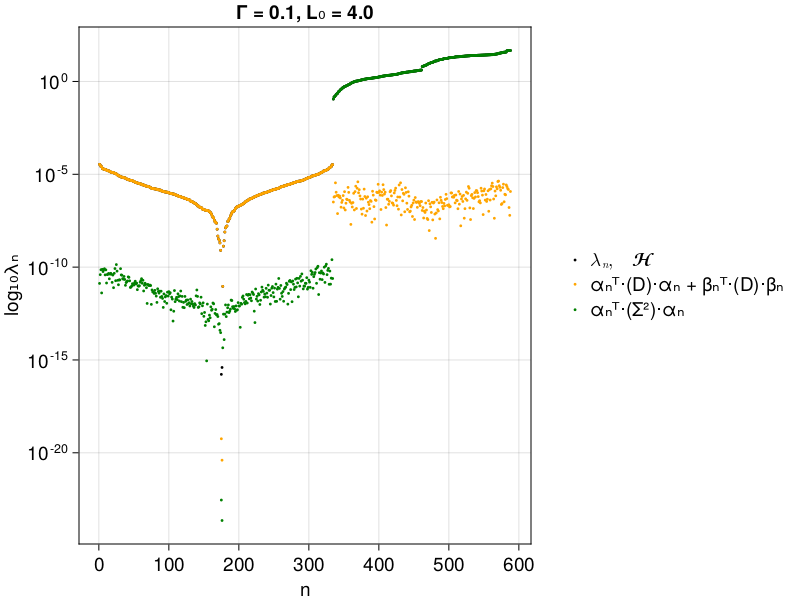

In [198]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
nD=LinRange(2*nVerts-2*nCells, 2*nVerts, 2*nCells-1)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="log₁₀λₙ",yscale=log10, title="Γ = "*string(params.γ)*", L₀ = "*string(params.L₀))

#scatter!(ax,nv, (abs.(evalLv)), color=:blue,markersize=4, label=L"\lambda_n,\quad \mathcal{L}_v^G")
scatter!(ax,nv, (abs.(evalH)), color=:black,markersize=4, label=L"\lambda_n,\quad \mathcal{H}")
#scatter!(ax,nv, lambda_s_beta_gX, color=:red,markersize=4, label="qₙᵀE⋅(Σ²+Zᵀ⋅gᵀX⋅Z)⋅qₙ")
scatter!(ax,nv, abs.([evecDD[:,x]'*(evecLv'*Matrix(mortar(gX))*evecLv)*evecDD[:,x] for x in 1:2nVerts]), color=:orange,markersize=4, label="αₙᵀ⋅(D)⋅αₙ + βₙᵀ⋅(D)⋅βₙ ")#
scatter!(ax,nv, abs.([evecDD[:,x]'*(Diagonal(vcat(zeros(2*nVerts-2*nCells),reverse(sNF.^2))))*evecDD[:,x] for x in 1:2nVerts]), color=:green,markersize=4, label="αₙᵀ⋅(Σ²)⋅αₙ")#

#scatter!(ax,nv,lambda_s_alpha_gX, color=:pink,markersize=4, label="αₙᵀ⋅(Zᵀ⋅gᵀX⋅Z)⋅αₙ + βₙᵀ⋅(Zᵀ⋅gᵀX⋅Z)⋅βₙ")

#scatter!(ax,nv,log10.(abs.(test)), color=:orange,markersize=4, label="σ²ₙ+ZₙE.gX.Zₙ")#
#vlines!(ax,2*nVerts+1/2-((2*nCells)), color=:red)

#vlines!(ax,2*nVerts+1/2-((nCells)), color=:red)

fig[1, 2] = Legend(fig, ax, framevisible = false)
# elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 10)]

# elem_2 = [MarkerElement(color = :blue, marker = :circle, markersize = 10)]
# Legend(fig[1, 2],
#     [elem_1, elem_2],
#     ["no peripheral vertices", "peripheral vertices"],
#     patchsize = (35, 35), rowgap = 10)
#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","map_spectra_split_log_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)
fig

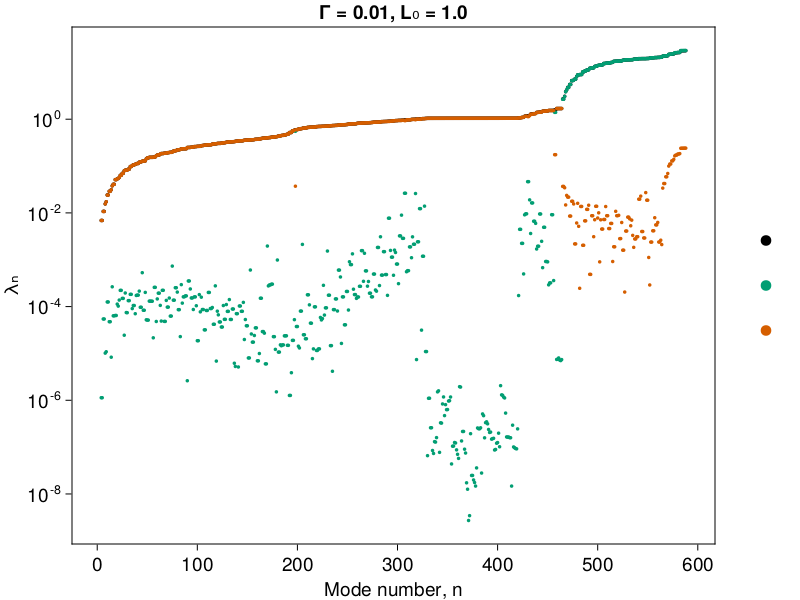

In [224]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
fig = Figure()
set_theme!(figure_padding=5, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
ax=Axis(fig[1, 1], xlabel="Mode number, n", ylabel="λₙ", yscale=log10, title="Γ = "*string(params.γ)*", L₀ = "*string(params.L₀))
hidedecorations!(ax, grid=true, ticks=false, label=false,ticklabels = false)
#vspan!(197.5, 396.5, color = (:grey, 0.3))
scatter!(ax,nv[4:end], ((abs.(evalH)))[4:end], color=:black,markersize=5, label=L"\lambda_n,\, \mathcal{H}")

#scatter!(ax,nv, (sort(abs.(evalLv))), color=ColorSchemes.seaborn_colorblind6[1],markersize=4, label=L"\lambda_n,\, \mathcal{L}_v^G")


scatter!(ax,nv[4:end], ((abs.(evmapLv)))[4:end], color=ColorSchemes.seaborn_colorblind6[2],markersize=5, label=L"\lambda_n,\, \mathcal{L}_v^G")
scatter!(ax,nv[4:end], ((abs.(evmapgX)))[4:end], color=ColorSchemes.seaborn_colorblind6[3],markersize=5, label=L"\lambda_n,\, \mathcal{H}")


elem_1 = [MarkerElement(color = :black, marker = :circle, markersize = 15)]

elem_2 = [MarkerElement(color = ColorSchemes.seaborn_colorblind6[2], marker = :circle, markersize = 15)]

elem_3 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 15)]

# # elem_4 = [MarkerElement(color =ColorSchemes.seaborn_colorblind6[3], marker = :circle, markersize = 12)]
Legend(fig[1, 2],
    [elem_1, elem_2, elem_3],
    ["","",""],
    patchsize = (35, 35), rowgap = 10, framevisible = false)
resize_to_layout!(fig)



#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","Mode_contributions_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)
fig

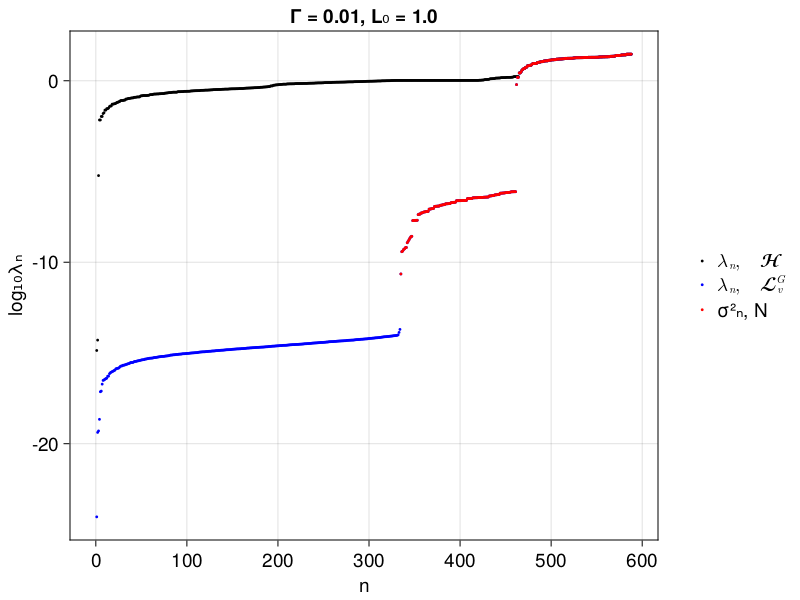

In [225]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
nc2=LinRange(1, 2*nCells, 2*nCells)
nD=LinRange(2*nVerts-2*nCells, 2*nVerts, 2*nCells-1)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="log₁₀λₙ", title="Γ = "*string(params.γ)*", L₀ = "*string(params.L₀))

scatter!(ax,nv, log10.(sort(abs.(evalH))), color=:black,markersize=4, label=L"\lambda_n,\quad \mathcal{H}")
scatter!(ax,nv, log10.(sort(abs.(evalLv))), color=:blue,markersize=4, label=L"\lambda_n,\quad \mathcal{L}_v^G")
scatter!(ax,nc, log10.((abs.(reverse(sNF.^2)))), color=:red,markersize=4, label="σ²ₙ, N")
#scatter!(ax,nv, log10.((abs.(evalEgX))), color=:red,markersize=4, label=L"\lambda_, \quad EgX")
#scatter!(ax,nc, log10.(sort(abs.(evalLc))), color=:red,markersize=4, label=L"\lambda_n,\quad \mathcal{L}_c^G")


#scatter!(ax,nv, (log10.((abs.([evecDD[:,x]'*Eflat*(evecLv'*Matrix(mortar(gX))*evecLv)*evecDD[:,x] for x in 1:2nVerts])))), color=:orange,markersize=4, label="qₙᵀE⋅(Zᵀ⋅gᵀX⋅Z)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDD[:,x]'*Eflat*(Diagonal(vcat(zeros(2*nVerts-2*nCells),reverse(sNF.^2))))*evecDD[:,x] for x in 1:2nVerts])))), color=:green,markersize=4, label="qₙᵀE⋅(Σ²)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDDs[:,x]'*Eflat*(Z[:, end:-1:1]'*Matrix(mortar(gX))*Z[:, end:-1:1])*evecDDs[:,x] for x in 1:2nVerts])))), color=:orange,markersize=4, label="qₙᵀE⋅(Zᵀ⋅gᵀX⋅Z)⋅qₙ")#
#scatter!(ax,nv, (log10.((abs.([evecDDs[:,x]'*Eflat*(Diagonal(vcat( zeros(2*nVerts-2*nCells),reverse(sNF.^2))))*evecDDs[:,x] for x in 1:2nVerts])))), color=:green,markersize=4, label="qₙᵀE⋅(Σ²)⋅qₙ")#

#scatter!(ax,nv, (log10.(sort(abs.(evecmap)))), color=:orange,markersize=4, label="λₙ, D+diag(σ²ₙ)")#
#scatter!(ax,nv[1:2*nVerts-2*nCells], (log10.((abs.(evecmap)[1:2*nVerts-2*nCells]))), color=:green,markersize=4, label="ZₙE.gX.Zₙ")
#scatter!(ax,nc,log10.(reverse(sMH.^2)), color=:pink,markersize=4, label="σ²ₙ, MH")#


#scatter!(ax,nv[1:2*nVerts-2*nCells], (log10.((abs.(testLv[1:2*nVerts-2*nCells])))), color=:green,markersize=4, label="ZₙE.gX.Zₙ")
#scatter!(ax,nv[2*nVerts+1-2*nCells:end],(log10.((abs.((testLv)[2*nVerts+1-2*nCells:end])))), color=:pink,markersize=4, label="σ²ₙ+ZₙE.gX.Zₙ, sorted")

#scatter!(ax,nv,log10.(abs.(test)), color=:orange,markersize=4, label="σ²ₙ+ZₙE.gX.Zₙ")#


#vlines!(ax,2*nVerts+1/2-((2*nCells)), color=:red)

#vlines!(ax,2*nVerts+19-((nCells)), color=:red)

fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","compare_spectra_log_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)
fig

In [ ]:
evalLv

In [201]:
mkpath(datadir(f,"eigenmodes", "spectra"))

for n=1:2*nVerts


    nv=LinRange(1, 2*nVerts, 2*nVerts)

    fig = Figure()
    ax=Axis(fig[1, 1],xlabel="n", ylabel="qₚₙ²Eₙ", title="n = "*string(n)*", Γ = "*string(params.γ)*", L₀ = "*string(params.L₀))

    scatter!(ax,nc,(((((evecDD[:,n].^2).*diag(Eflat))[2*nVerts-(2*nCells)+1:end]))), color=:black,markersize=4)
    vlines!(ax,2*nVerts+1/2-((2*nCells)), color=:red)

    vlines!(ax,2*nVerts+1/2-((nCells)), color=:red)


    #hidedecorations!(ax22)
    #hidespines!(ax22)

    #colsize!(fig.layout,1,Aspect(1,1.0))


    #Label( fig[0,:],"n = "*string(n)*"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
    #resize_to_layout!(fig)
    save(datadir(f,"eigenmodes", "spectra","spectramap_lambda_$(@sprintf("%03d", n)).png"),fig)

    #display(fig)
end


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\v35431nc\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\v35431nc\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\v35431nc\.julia\packages\PlotUtils\mHQ0Q\src\ticks.jl:191


In [ ]:
nv=LinRange(1, 2*nVerts, 2*nVerts)
nc=LinRange(2*nVerts-2*nCells+1, 2*nVerts, 2*nCells)
nD=LinRange(2*nVerts-2*nCells, 2*nVerts, 2*nCells-1)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel=string(L"|ΔU_{Area}/ΔU_{Perimeter}|"), title="Area Energy, Perimeter energy, H, Γ = "*string(params.γ)*", L₀ = "*string(params.L₀))

#scatter!(ax,nv, ((ones(100)'*zMH[1:100,:])'), color=:black,markersize=4, label="ΔU")
#scatter!(ax,nv, (ones(100)'*(Mflat*(evecDD'*evecH*evecDD)))', color=:blue,markersize=4, label="ΔU")

scatter!(ax,nv[1:end-2], (((g'*MevH)'))[1:end-2], color=:black,markersize=4, label="MH")
#scatter!(ax,nc[2:end], (((((g'*MevLvnorm)')[2*nVerts-2*nCells+2:end]))), color=:blue,markersize=4, label="MLv")
#scatter!(ax,nv, sum(Mflat*evecH, dims=1)', color=:black,markersize=4, label="Lc")
#scatter!(ax,nv, (g[1:100]'*(Mflat*(evecH))[1:100,:])', color=:red,markersize=4, label="ΔArea")
#scatter!(ax,nv, (g[101:end]'*(Mflat*(evecH))[101:end,:])', color=:blue,markersize=4, label="ΔPerimeter")
#scatter!(ax,nc,abs.(( (cellPressures'*evecLc[1:100,:])')./(-cellTensions'*evecLc[101:end,:])'), color=:black,markersize=4, label="Lc")
#scatter!(ax,nv, (abs.(( (cellPressures'*MevH[1:100,:])')./(-cellTensions'*MevH[101:end,:])')), color=:black,markersize=4, label="H")
#scatter!(ax, nc,sort(log10.(abs.((g'*inv(sqrt(G))*Matrix(qr(MevH[:, 2*nVerts-2*nCells+1:end]).Q))'))), color=:orange,markersize=4, label="ΔU")
#scatter!(ax,nv,((abs.((( (ones(100)'*MevH[101:end,:])').^2)./((ones(100)'*MevH[1:100,:])')))), color=:orange,markersize=4, label="ΔU")


#hlines!(ax,0.5*g'*(vcat(cellAreas.-1, cellPerimeters.-1)) )
#hlines!(ax, g'*(vcat(cellAreas.-1, cellPerimeters.-1)))

vlines!(ax,2*nVerts-((2*nCells))+1/2, color=:red)

vlines!(ax,2*nVerts-((nCells)+1/2), color=:red)
fig[1, 2] = Legend(fig, ax, framevisible = false)
#save(datadir(f,"eigenmodes","Ratio_Area_Perimeter_energy_H_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)
fig

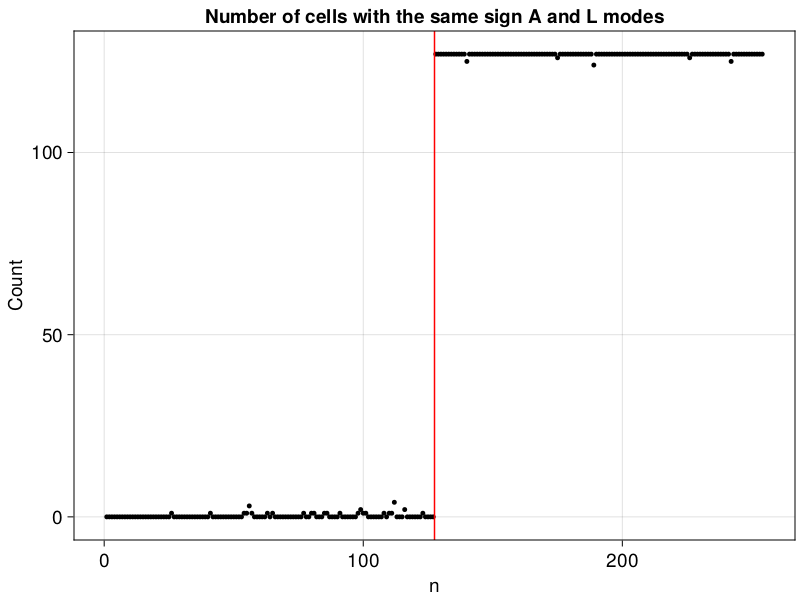

In [226]:
modeSign=zeros(2*nCells)
mode_mag_plus=zeros(2*nCells)
mode_mag_minus=zeros(2*nCells)
mode_magL_plus=zeros(2*nCells)
mode_magL_minus=zeros(2*nCells)
mode_magA_plus=zeros(2*nCells)
mode_magA_minus=zeros(2*nCells)
for n=1:2*nCells
    a=evecLc[1:nCells,n].*evecLc[nCells+1:end,n]
    bA=evecLc[1:nCells,n]
    bL=evecLc[nCells+1:end,n]
    modeSign[n]=length(a[a.>0])
    mode_mag_plus[n]=sum(a[a.>0])
    mode_mag_minus[n]=sum(a[a.<0])
    mode_magL_plus[n]=sum(bL[a.>0])
    mode_magL_minus[n]=sum(bL[a.<0])
    mode_magA_plus[n]=sum(bA[a.>0])
    mode_magA_minus[n]=sum(bA[a.<0])
end
n=LinRange(1, 2*nCells, 2*nCells)
fig = Figure()
ax=Axis(fig[1, 1], xlabel="n", ylabel="Count", title="Number of cells with the same sign A and L modes")

#scatter!(ax,n, mode_magL_plus, color=:red, label="Σ L modes, same sign", markersize=7)
scatter!(ax,n, modeSign, color=:black, label="Σ L modes, opposite", markersize=7)
# scatter!(ax,n, mode_magA_plus.+ mode_magL_plus, color=:red, label="Σ same sign", markersize=7)
# scatter!(ax,n, mode_magA_minus.+ mode_magL_minus, color=:blue, label="Σ opposite sign", markersize=7)

#vlines!(ax,2*nVerts-(2*nCells) +0.5, color=:red)
vlines!(ax,nCells+0.5, color=:red)
#fig[1, 2] = Legend(fig, ax, framevisible = false)
save(datadir(f,"eigenmodes","mode_sign.png"),fig)
fig

In [227]:
writedlm(datadir(f,"eigenmodes","LcE_eigenvalues.csv"), evalLc, ',') 
writedlm(datadir(f,"eigenmodes","LcE_eigenvectors.csv"), evecLc, ',') 
writedlm(datadir(f,"eigenmodes","LvE_eigenvalues.csv"), evalLv, ',') 
writedlm(datadir(f,"eigenmodes","LvE_eigenvectors.csv"), evecLv, ',') 
writedlm(datadir(f,"eigenmodes","HE_eigenvalues.csv"), evalH, ',') 
writedlm(datadir(f,"eigenmodes","HE_eigenvectors.csv"), evecH, ',') 
writedlm(datadir(f,"eigenmodes","DppE_tot_diag_sigma_eigenvalues.csv"), evalDD, ',') 
writedlm(datadir(f,"eigenmodes","DppE_tot_diag_sigma_eigenvectors.csv"), evecDD, ',') 
writedlm(datadir(f,"eigenmodes","svd_N_Y.csv"), Y, ',') 
writedlm(datadir(f,"eigenmodes","svd_N_Z.csv"), Z, ',') 
writedlm(datadir(f,"eigenmodes","svd_N_sigma.csv"), sNF, ',') 

In [ ]:
writedlm(datadir(f,"eigenmodes","LvE.csv"), Matrix(mortar(LvE)), ',') 
writedlm(datadir(f,"eigenmodes","gX.csv"), Matrix(mortar(gX)), ',') 


writedlm(datadir(f,"eigenmodes","HE.csv"), HE, ',') 
writedlm(datadir(f,"eigenmodes","E.csv"), E, ',') 

writedlm(datadir(f,"eigenmodes","LcE.csv"), LcE*G, ',') 

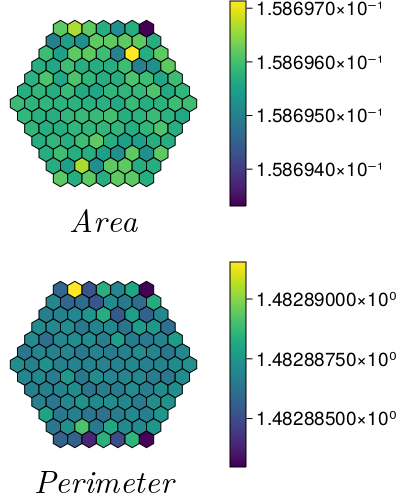

In [237]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
Levlims=(minimum(abs.(cellPerimeters[1:nCells])), maximum(abs.(cellPerimeters[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())
a2=Axis(fig[2,1],aspect=DataAspect())
hidedecorations!(a1)
hidespines!(a1)
hidedecorations!(a2)
hidespines!(a2)
for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellAreas[i],colormap=:viridis,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a2,cellPolygons[i],color=cellPerimeters[i],colormap=:viridis,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)


Label(fig[1,1,Bottom()],string(L"Area"),fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],string(L"Perimeter"),fontsize = 32, rotation=0)
#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
save(datadir(f,"eigenmodes","Area_Perimeter.png"),fig)
fig

In [ ]:
cellAreas

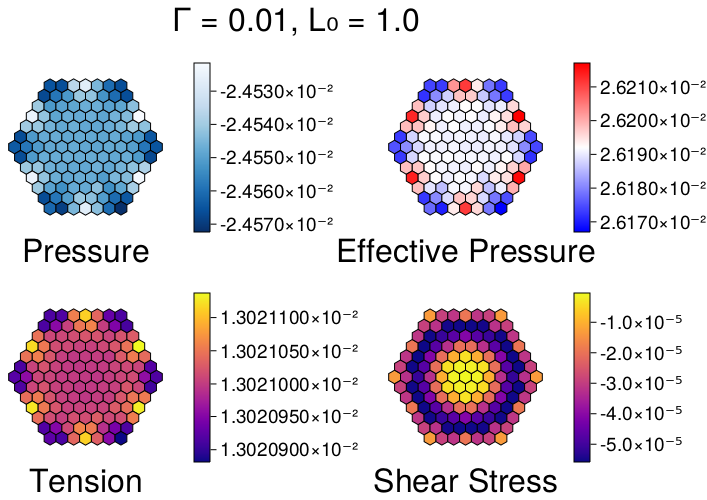

CairoMakie.Screen{IMAGE}


In [229]:
Peff=getPeff(params, matrices)
cellQ, cellJ=makeCellQandJ(params, matrices)
cellShearStress=getShearStress(params, matrices, cellJ)

cellPolygons = makeCellPolygons(R,params,matrices)
@unpack cellAreas, cellPerimeters, cellPressures, cellTensions = matrices
Plims=(minimum(cellPressures[1:nCells]), maximum(cellPressures[1:nCells]))
Tlims=(minimum(-cellTensions[1:nCells]), maximum(-cellTensions[1:nCells]))
Pefflims=(minimum((Peff)), maximum((Peff)))
ShStlims=(minimum(cellShearStress[1:nCells]), maximum(cellShearStress[1:nCells]))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a11=Axis(fig[1,1],aspect=DataAspect())
a21=Axis(fig[2,1],aspect=DataAspect())
a13=Axis(fig[1,3],aspect=DataAspect())
a23=Axis(fig[2,3],aspect=DataAspect())
hidedecorations!(a11)
hidespines!(a11)
hidedecorations!(a21)
hidespines!(a21)
hidedecorations!(a13)
hidespines!(a13)
hidedecorations!(a23)
hidespines!(a23)
for i=1:nCells
    poly!(a11,cellPolygons[i],color=cellPressures[i],colormap=cgrad(:Blues_9, rev=true),colorrange=Plims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a21,cellPolygons[i],color=-cellTensions[i],colormap=:plasma,colorrange=Tlims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a13,cellPolygons[i],color=Peff[i],colormap=:bwr,colorrange=Pefflims, strokecolor=(:black,1.0),strokewidth=1)
    poly!(a23,cellPolygons[i],color=cellShearStress[i],colormap=:plasma,colorrange=ShStlims, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))

colsize!(fig.layout,3,Aspect(1,1.0))


Colorbar(fig[1,2],limits=colorrange=Plims,colormap=cgrad(:Blues_9, rev=true),flipaxis=true)
Colorbar(fig[2,2],limits=colorrange=Tlims,colormap=:plasma,flipaxis=true)
Colorbar(fig[1,4],limits=colorrange=Pefflims,colormap=:bwr,flipaxis=true)
Colorbar(fig[2,4],limits=colorrange=ShStlims,colormap=:plasma,flipaxis=true)

Label(fig[1,1,Bottom()],"Pressure",fontsize = 32, rotation=0)
Label(fig[2,1,Bottom()],"Tension",fontsize = 32, rotation=0)

Label(fig[1,3,Bottom()],"Effective Pressure",fontsize = 32, rotation=0)
Label(fig[2,3,Bottom()],"Shear Stress",fontsize = 32, rotation=0)
Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#save(datadir(f,"eigenmodes","Stress.png"),fig)
save(datadir(f,"eigenmodes","stress_pressure_Γ_"*string(params.γ)*"_L0_"*string(params.L₀)*".png"),fig)

display(fig)

In [230]:
cellPolygons = makeCellPolygons(R,params,matrices)

for n=1:2*nCells

    Aevlims=(-maximum(abs.(Y[1:nCells,n])), maximum(abs.(Y[1:nCells, n])))
    Levlims=(-maximum(abs.(Y[ nCells+1:2*nCells,n])), maximum(abs.(Y[nCells+1:2*nCells, n])))
    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(resolution=(1500,500))

    a1=Axis(fig[1,1],aspect=DataAspect())
    a2=Axis(fig[2,1],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    for i=1:nCells
        poly!(a1,cellPolygons[i],color=[Y[1:nCells,n][i]],colormap=:bwr,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
        poly!(a2,cellPolygons[i],color=[Y[nCells+1:2*nCells,n][i]],colormap=:bwr,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
    end
    Label(fig[2,1,Bottom()],"λ_"*string(2*nCells-(n-1))*" = "*@sprintf("%.5E", sNF[n]^2),fontsize = 32)

    #hidedecorations!(ax22)
    #hidespines!(ax22)

    colsize!(fig.layout,1,Aspect(1,1.0))


    Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:bwr,flipaxis=true)
    Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:bwr,flipaxis=true)


    Label(fig[1,1,Left()],string(L"Area"),fontsize = 32, rotation=π/2)
    Label(fig[2,1,Left()],string(L"Perimeter"),fontsize = 32, rotation=π/2)
    #Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)
    save(datadir(f,"eigenmodes","eigenmodes_Y$(@sprintf("%03d", 2*nCells-(n-1))).png"),fig)

    #display(fig)
end




In [ ]:
sum(cellAreas.*(log.(cellAreas).-1)+(γ*L₀).*cellPerimeters.*(log.(cellPerimeters./L₀).-1))

In [ ]:
(γ*L₀).*cellPerimeters.*(log.(cellPerimeters./L₀).-1)

In [ ]:
(γ*L₀).*(log.(cellPerimeters./L₀))
log.(cellAreas)

In [ ]:
s_alpha_norm=inv(sqrt(G))*qr(sqrt(G)*s_alpha_sum).Q

s_alpha_norm'*G*s_alpha_norm

#Q=zeros(200, 200)
s_alpha_norm_gs=zeros(200,200)
# for j=1:2*nCells
#     s_alpha_norm_gs[:,j]=s_alpha_sum[:,end: -1:1][:,j]
# end

# for j=1:2*nCells
#     Q[:,j]=s_alpha_norm_gs[:,j] /sqrt(s_alpha_norm_gs[:,j]'*G*s_alpha_norm_gs[:,j])
#        for k=j+1:2*nCells
#              s_alpha_norm_gs[:,k]=s_alpha_norm_gs[:,k]−(Q[:,j]'*G*s_alpha_norm_gs[:,k])*Q[:,j]
#        end
# end



s_alpha_norm_gs[:,1]=s_alpha_sum[:, end:-1:1][:,1]
for i in 2:2*nCells
    s_alpha_norm_gs[:,i] = s_alpha_sum[:, end:-1:1][:, i]
    for j in 1:(i-1)
        s_alpha_norm_gs[:, i] -= (s_alpha_norm_gs[:, j]'*G*s_alpha_sum[:, end:-1:1][:, i])*s_alpha_norm_gs[:, j]/(s_alpha_norm_gs[:,j]'*G*s_alpha_norm_gs[:,j])
    end
end

s_alpha_norm_gs=mapslices(x -> x /sqrt(x'*G*x),s_alpha_norm_gs, dims=1)
s_alpha_norm_gs=s_alpha_norm_gs[:,end:-1:1]


s_alpha_norm_gs'*G*s_alpha_norm_gs

In [ ]:
M_EgX=Mflat*evecEgX

In [ ]:
mkpath(datadir(f,"eigenmodes", "M_evecH"))
cellPolygons = makeCellPolygons(R,params,matrices)
for n=1:2*nVerts

    Aevlims=(-maximum(abs.(MevH[1:nCells,n])), maximum(abs.(MevH[1:nCells, n])))
    Levlims=(-maximum(abs.(MevH[ nCells+1:2*nCells,n])), maximum(abs.(MevH[nCells+1:2*nCells, n])))
    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(resolution=(1500,500))

    a1=Axis(fig[1,1],aspect=DataAspect())
    a2=Axis(fig[2,1],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    for i=1:nCells
        poly!(a1,cellPolygons[i],color=[MevH[1:nCells,n][i]],colormap=:bwr,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
        poly!(a2,cellPolygons[i],color=[MevH[nCells+1:2*nCells,n][i]],colormap=:bwr,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
    end
    Label(fig[2,1,Bottom()],"n = "*string(n),fontsize = 32)

    #hidedecorations!(ax22)
    #hidespines!(ax22)

    colsize!(fig.layout,1,Aspect(1,1.0))


    Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:bwr,flipaxis=true)
    Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:bwr,flipaxis=true)


    Label(fig[1,1,Left()],string(L"Area"),fontsize = 32, rotation=π/2)
    Label(fig[2,1,Left()],string(L"Perimeter"),fontsize = 32, rotation=π/2)
    #Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)
    save(datadir(f,"eigenmodes", "M_evecH","MevH$(@sprintf("%03d", n)).png"),fig)

    #display(fig)
end

In [ ]:
cellPolygons = makeCellPolygons(R,params,matrices)
for n=1:2*nVerts

    Aevlims=(-maximum(abs.(M_EgX[1:nCells,n])), maximum(abs.(M_EgX[1:nCells, n])))
    Levlims=(-maximum(abs.(M_EgX[ nCells+1:2*nCells,n])), maximum(abs.(M_EgX[nCells+1:2*nCells, n])))
    set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
    fig = Figure(resolution=(1500,500))

    a1=Axis(fig[1,1],aspect=DataAspect())
    a2=Axis(fig[2,1],aspect=DataAspect())
    hidedecorations!(a1)
    hidespines!(a1)
    hidedecorations!(a2)
    hidespines!(a2)
    for i=1:nCells
        poly!(a1,cellPolygons[i],color=[M_EgX[1:nCells,n][i]],colormap=:bwr,colorrange=Aevlims, strokecolor=(:black,1.0),strokewidth=1)
        poly!(a2,cellPolygons[i],color=[M_EgX[nCells+1:2*nCells,n][i]],colormap=:bwr,colorrange=Levlims, strokecolor=(:black,1.0),strokewidth=1)
    end
    Label(fig[2,1,Bottom()],"n = "*string(n),fontsize = 32)

    #hidedecorations!(ax22)
    #hidespines!(ax22)

    colsize!(fig.layout,1,Aspect(1,1.0))


    Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:bwr,flipaxis=true)
    Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:bwr,flipaxis=true)


    Label(fig[1,1,Left()],string(L"Area"),fontsize = 32, rotation=π/2)
    Label(fig[2,1,Left()],string(L"Perimeter"),fontsize = 32, rotation=π/2)
    #Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
    resize_to_layout!(fig)
    save(datadir(f,"eigenmodes","M_evEgX","MevEgX$(@sprintf("%03d", n)).png"),fig)

    #display(fig)
end

In [ ]:
cellPolygons = makeCellPolygons(R,params,matrices)
Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
Levlims=(minimum(abs.(cellPerimeters[1:nCells])), maximum(abs.(cellPerimeters[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,500))

a1=Axis(fig[1,1],aspect=DataAspect())

for i=1:nCells
    poly!(a1,cellPolygons[i],color=:white, strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


#Colorbar(fig[1,2],limits=colorrange=Aevlims,colormap=:viridis,flipaxis=true)
#Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)

#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
resize_to_layout!(fig)
#arrows!(a1, Point2f.(R), Vec2f.(hcat(evecH[1:2:end,3], evecH[2:2:end,3])), color=:green)
save(datadir(f,"eigenmodes","config.png"),fig)
fig

In [ ]:
minimum(cellEdgeCount)

In [ ]:
cellPolygons = makeCellPolygons(R,params,matrices)
#Aevlims=(minimum(abs.(cellAreas[1:nCells])), maximum(abs.(cellAreas[1:nCells])))
#Levlims=(minimum(abs.(cellPerimeters[1:nCells])), maximum(abs.(cellPerimeters[1:nCells])))
set_theme!(figure_padding=1, backgroundcolor=(:white,1.0), font="Helvetica", fontsize=19)
fig = Figure(resolution=(1500,1000))

a1=Axis(fig[1,1],aspect=DataAspect())

for i=1:nCells
    poly!(a1,cellPolygons[i],color=cellEdgeCount[i], colorrange=(minimum(cellEdgeCount),maximum(cellEdgeCount)), colormap=ColorSchemes.Java,strokecolor=(:black,1.0),strokewidth=1)
end
#Label(fig[2,1,Bottom()],"λ_"*string(n)*" = "*@sprintf("%.5E", evals[n]),fontsize = 32)

#hidedecorations!(ax22)
#hidespines!(ax22)

colsize!(fig.layout,1,Aspect(1,1.0))


cbar=Colorbar(fig[1,2],limits=(minimum(cellEdgeCount),maximum(cellEdgeCount)),colormap=cgrad(ColorSchemes.Java, length(unique(cellEdgeCount)), categorical=true),flipaxis=true)
cbar.ticks = ([4.4, 5.2, 6,6.8, 7.6], ["4", "5", "6","7", "8"])
#Colorbar(fig[2,2],limits=colorrange=Levlims,colormap=:viridis,flipaxis=true)

#Label( fig[0,:],"Γ = "*string(params.γ)*", L₀ = "*string(params.L₀)*", δL = "*string(params.δL),fontsize = 32, color = (:black, 1))
#resize_to_layout!(fig)
#arrows!(a1, Point2f.(R), Vec2f.(hcat(evecH[1:2:end,6], evecH[2:2:end,6])), color=:green)
fig

In [ ]:

Peff=getPeff(params, matrices)
cellQ, cellJ=makeCellQandJ(params, matrices)
cellShearStress=getShearStress(params, matrices, cellJ)
shapeParameter=cellPerimeters./sqrt.(cellAreas)